## Import Libraries

In [41]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 , ResNet50
import matplotlib.pyplot as plt

In [42]:
folder_name = 'Quantum_Converted'
height = 256
width = 256
channels  = 3
format = 'rgb' # Image Format

### Create train dataset

In [43]:
df = pd.DataFrame(data= None , columns= ['label' , 'filename'])
dataset_path = os.getcwd().replace('notebook' , '') + folder_name
count = 0
for folder in [i for i in os.listdir(dataset_path) if i not in ['.DS_Store' , 'label.csv']]:
    for i , file in enumerate(os.listdir(dataset_path + '/' + folder)):
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                  df.loc[count + i] = [folder, file]
            count += len(os.listdir(dataset_path + '/' + folder))
df.to_csv(os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv')

## Pre Processing

In [44]:
label_df_path = os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv' 
df = pd.read_csv(label_df_path , index_col=0)

# One Hot Encode genre file
df_encoded = pd.get_dummies(df['label'], columns=['label'])

y = df_encoded.values

### Metric Visualisation

In [45]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['categorical_accuracy'])
  plt.plot(epochRange,history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

## Modelling

### VGG16

#### Image Processing

In [46]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:04<00:00, 127.99it/s]


### Tranfer Learning weights freezed

In [47]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │   134,221,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,738,309 (632.24 MB)

 Trainable params: 151,023,621 (576.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
est = model.fit(x_train,y_train , epochs=20 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/20
 7/15 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - categorical_accuracy: 0.2701 - loss: 18.6056

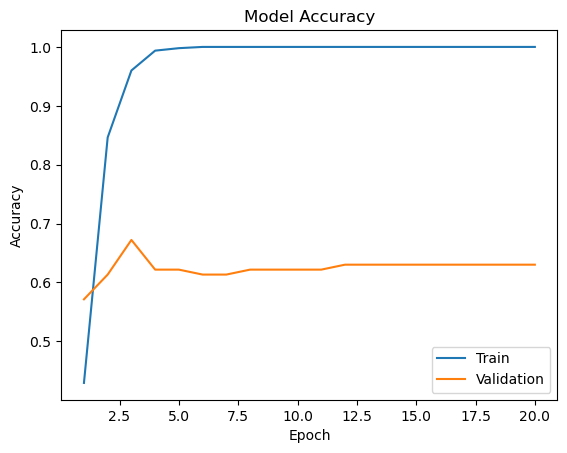

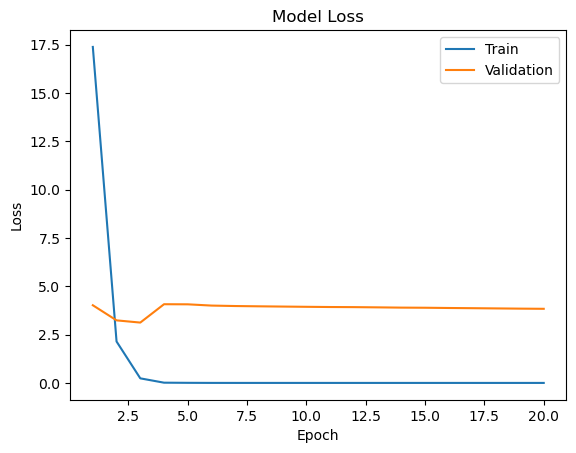

In [10]:
plotLearningCurve(est,20)

### ResNet50

#### Image Preprocessing

In [ ]:
from tensorflow.keras.applications.ResNet50 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
est = model.fit(x_train,y_train , epochs=20 , batch_size=32 , validation_data=(x_test,y_test))